<font size='5'>Variational Inference - Sampling the generative model</font>

Using variational inference applied to time series data, the algorithm non-parametrically chooses a likely number of clusters each with distinct <b>mean and covariance</b> parameters allowing computation of a likelihood function for the 3-dimensional point at any time step. The model optimizes the parameters of the i clusters to maximize the likelihood of those parameters given the data. Similarity between probability distributions is measured via the KL-divergence. Comparing the distributions at each of the i-th clusters and then deriving a total entropy score:

$D_{KL}(P \parallel Q) = \sum_{i} P(i) \log \frac{P(i)}{Q(i)}$

In practice this works out to function as an unsupervised classification algorithm for the most likely distribution (mean and covariance) a time step belongs to. This is applicable to discovering statistical market regime-shifts where the parameters of interest (mean and covariance) are shifting.

This variant of the notebook will sample from the posterior distribution over the parameters of the latent states, and their transition matrix that gives us a probability of switching to any given state based on the empirically observed data. This does not make a prediction, instead only <b>describes</b> the historical data and then re-samples it using the state-transitioning Markov approach where the probability of re-sampling a given state should be proportional to it's posterior weight. 

In [6]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

import sklearn 
import sklearn.mixture as mix 

Testing a small universe of the 10Y Treasury, a Commodity ETF, and Tech ETF. The goal will be time series clustering using variational inference. There are periods of time (regimes) where certain assets outperform the others and their precise relationship is captured by the latent state. 

Set num_components to a very high number so the data is fit in a non-parametric way where we need not know the number of clusters in advance. 

In [7]:
assetlist = [ 'IEF', 'GSG', 'IXN' ]
num_components = 99

Create the subset of assets.

In [8]:
m6 = pd.read_csv('./data/assets_m6.csv')
m6_assets = pd.DataFrame()

for sym in assetlist: 
    m6_assets[sym] = m6[m6['symbol'] == sym]['price'].values

Formatting the training data. 1st-order differencing of the log price for each asset. View auto-correlation.

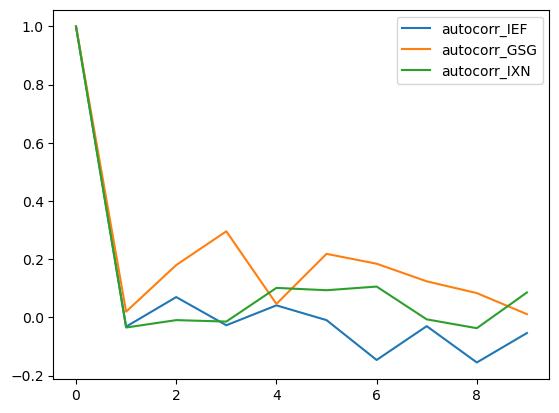

In [9]:
m6_subset = m6_assets.copy().apply(np.log).apply(np.diff)
m6_subset = m6_subset.dropna().reset_index().drop(columns='index')

autocorr_df = pd.DataFrame()
autocorr_df['decay_IEF'] = m6_subset['IEF'].apply(abs)
autocorr_df['decay_GSG'] = m6_subset['GSG'].apply(abs) 
autocorr_df['decay_IXN'] = m6_subset['IXN'].apply(abs) 
decay_func = lambda S, _range: [S.autocorr(lag=Lag) for Lag in _range]

sns.lineplot(data=decay_func(autocorr_df['decay_IEF'], range(0, 10)), label='autocorr_IEF') 
sns.lineplot(data=decay_func(autocorr_df['decay_GSG'], range(0, 10)), label='autocorr_GSG')
sns.lineplot(data=decay_func(autocorr_df['decay_IXN'], range(0, 10)), label='autocorr_IXN')
plt.show()

Instantiate a non-parametric clustering model using the dirichlet process. Then, sample 255 separate individual draws from the variational model. This sampling should respect the empirical transition matrix of the data, which is a matrix of probabilities for switching to any given state from the current state. E.g. if the model finds 5 distinct latent states, the matrix would take the form, 

P = \begin{bmatrix}
p_{1,1} & p_{1,2} & p_{1,3} & p_{1,4} & p_{1,5} \\
p_{2,1} & p_{2,2} & p_{2,3} & p_{2,4} & p_{2,5} \\
p_{3,1} & p_{3,2} & p_{3,3} & p_{3,4} & p_{3,5} \\
p_{4,1} & p_{4,2} & p_{4,3} & p_{4,4} & p_{4,5} \\
p_{5,1} & p_{5,2} & p_{5,3} & p_{5,4} & p_{5,5} \\
\end{bmatrix}

In [10]:
dpgmm_model = mix.BayesianGaussianMixture(n_components=num_components, weight_concentration_prior_type='dirichlet_process')

In [11]:
# Fit the model
dpgmm_model.fit(m6_subset)
states = []
samples = []

# Sample 255 from the generative model 
for s in range(255):
    sample, y = dpgmm_model.sample(1)
    states.append(y[0])
    samples.append(sample[0])

df = pd.DataFrame()
df['0']=[ s[0] for s in samples ]
df['1']=[ s[1] for s in samples ]
df['2']=[ s[2] for s in samples ]

# Count the frequency of each latent state 
state_counts = np.zeros(num_components)
for M in states:
  state_counts[M] += 1 

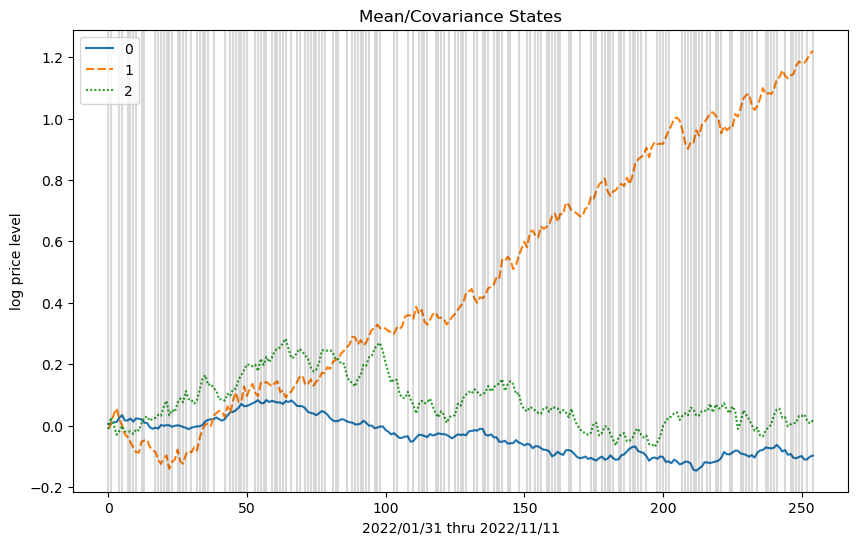

In [12]:
fig,ax = plt.subplots(figsize=(10, 6
                              ))
sns.lineplot(data=df.cumsum(), ax=ax)

for M in range(len(states)): 
  if states[M] == np.argmax(state_counts):
    ax.axvline(M, color='black', alpha=0.15)

ax.set_title('Mean/Covariance States')
ax.set_ylabel('log price level')
ax.set_xlabel(f'2022/01/31 thru 2022/11/11')
plt.show()

In [13]:
print(dpgmm_model.means_[:10])

[[-0.00073977  0.00083497 -0.00104284]
 [-0.00073974  0.0008348  -0.00104289]
 [-0.00034945 -0.00119093  0.00513586]
 [-0.00145021  0.00673821 -0.01460924]
 [-0.00073569  0.00081475 -0.00104866]
 [-0.00073435  0.00080801 -0.0010506 ]
 [-0.00073386  0.00080557 -0.0010513 ]
 [-0.00073368  0.00080467 -0.00105156]
 [-0.00346423 -0.05625835  0.01969309]
 [-0.00073358  0.00080413 -0.00105171]]
